# Speech Commands Dataset - Deep Dive with Visualizations

## Introduction

In this notebook, we'll work with **real audio data** from the Speech Commands Dataset. Unlike our synthetic phoneme data from Notebook 1, this dataset contains actual human speech with natural co-articulation effects, making it perfect for demonstrating RNN superiority.

### Learning Objectives

1. Download and explore the Speech Commands Digits dataset
2. Understand the complete audio processing pipeline
3. Extract MFCC features from real speech
4. Visualize temporal patterns in spoken digits
5. Prepare data for RNN training

### Dataset Overview

**Speech Commands Dataset (Digits Subset)**
- **Words**: "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"
- **Size**: ~200MB (10 digits)
- **Samples**: ~20,000 audio clips (~2,000 per digit)
- **Duration**: 1 second per clip
- **Sample Rate**: 16kHz
- **Speakers**: Multiple speakers with various accents

### Why This Dataset?

Real speech has properties that make temporal modeling essential:
- **Co-articulation**: Sounds blend together naturally
- **Speaking rate variation**: Different speeds
- **Accent diversity**: Different pronunciations
- **Prosody**: Natural rhythm and intonation

These properties create **ambiguous frames** that require temporal context to classify correctly - perfect for demonstrating RNN advantages!

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import urllib.request
import tarfile
from pathlib import Path
from tqdm import tqdm
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Librosa version: {librosa.__version__}")

✓ Libraries imported successfully!
NumPy version: 2.0.2
Librosa version: 0.11.0


## 1. Audio Processing Pipeline Overview

Before downloading the data, let's understand the complete pipeline for converting raw audio to features suitable for RNN training.

### Complete Pipeline Diagram

```
┌─────────────────────────────────────────────────────────────────────┐
│                    AUDIO PROCESSING PIPELINE                        │
└─────────────────────────────────────────────────────────────────────┘

Step 1: RAW AUDIO
┌─────────────────┐
│  "seven.wav"    │  • Duration: 1 second
│  16,000 samples │  • Sample rate: 16kHz
│  Mono channel   │  • Format: WAV
└────────┬────────┘
         │
         ▼
Step 2: FRAMING
┌─────────────────┐
│   Split into    │  • Window: 25ms (400 samples)
│   overlapping   │  • Hop: 10ms (160 samples)
│   frames        │  • Result: ~100 frames
└────────┬────────┘
         │
         ▼
Step 3: WINDOWING
┌─────────────────┐
│  Apply Hamming  │  • Reduces spectral leakage
│  window to each │  • Smooth frame boundaries
│  frame          │  • w[n] = 0.54 - 0.46·cos(2πn/N)
└────────┬────────┘
         │
         ▼
Step 4: FFT (Fast Fourier Transform)
┌─────────────────┐
│  Time → Freq    │  • 512-point FFT
│  domain         │  • Power spectrum
│  conversion     │  • |FFT|² → Energy per frequency
└────────┬────────┘
         │
         ▼
Step 5: MEL FILTERBANK
┌─────────────────┐
│  Apply 40 mel   │  • Mimics human hearing
│  filters        │  • More resolution at low freq
│                 │  • Less resolution at high freq
└────────┬────────┘
         │
         ▼
Step 6: LOG COMPRESSION
┌─────────────────┐
│  log(mel_spec)  │  • Mimics loudness perception
│                 │  • Compresses dynamic range
│                 │  • log₁₀(x + ε)
└────────┬────────┘
         │
         ▼
Step 7: DCT (Discrete Cosine Transform)
┌─────────────────┐
│  Decorrelate    │  • Keep first 13 coefficients
│  features       │  • MFCCs = DCT(log mel spectrum)
│                 │  • Compact representation
└────────┬────────┘
         │
         ▼
FINAL OUTPUT
┌─────────────────┐
│  MFCC Matrix    │  • Shape: (100 frames, 13 coeffs)
│  100 × 13       │  • Ready for RNN input
│                 │  • Temporal sequence preserved
└─────────────────┘
```

### Key Parameters

| Parameter | Value | Reason |
|-----------|-------|--------|
| Sample Rate | 16kHz | Standard for speech (captures up to 8kHz) |
| Frame Length | 25ms | Captures phonetic information |
| Frame Hop | 10ms | 60% overlap for smooth transitions |
| FFT Size | 512 | Power of 2, sufficient resolution |
| Mel Filters | 40 | Standard for speech recognition |
| MFCC Coeffs | 13 | Captures essential spectral envelope |

### Why MFCCs?

MFCCs (Mel-Frequency Cepstral Coefficients) are ideal for speech because:
1. **Perceptually motivated**: Mel scale matches human hearing
2. **Compact**: 13 numbers capture essential information
3. **Decorrelated**: DCT removes redundancy
4. **Robust**: Less sensitive to noise than raw spectrum
5. **Standard**: Widely used in speech recognition

## 2. Download Speech Commands Dataset

We'll download only the digit folders to keep the size manageable (~200MB instead of 2GB).

In [15]:
def download_speech_commands(force=False):
    """Download and extract Speech Commands dataset."""
    
    # Create data directory
    DATA_DIR.mkdir(exist_ok=True, parents=True)
    
    # Check if already downloaded (unless force=True)
    if not force and all((DATA_DIR / digit).exists() for digit in DIGITS):
        print("✓ Dataset already downloaded!")
        return
    
    print("Downloading Speech Commands dataset...")
    print("This may take a few minutes (~2GB download)")
    
    # Download
    tar_path = DATA_DIR / 'speech_commands.tar.gz'
    
    if not tar_path.exists():
        # Download with progress bar
        import requests
        response = requests.get(DATASET_URL, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(tar_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                pbar.update(size)
        
        print("\n✓ Download complete!")
    else:
        print("✓ Using existing download")
    
    # Extract only digit folders
    print("\nExtracting digit folders...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        # Fixed: Look for ./digit/ pattern
        members = [m for m in tar.getmembers() 
                  if any(f'/{digit}/' in m.name or m.name == f'./{digit}' for digit in DIGITS)]
        
        print(f"Found {len(members)} files to extract")
        
        for member in tqdm(members, desc="Extracting"):
            tar.extract(member, DATA_DIR)
    
    print("\n✓ Extraction complete!")
    
    # Clean up
    if tar_path.exists():
        tar_path.unlink()
        print("✓ Cleaned up temporary files")

# Run download
download_speech_commands(force=True)

# Verify
print("\n" + "="*50)
print("DATASET STATISTICS")
print("="*50)
for digit in DIGITS:
    digit_path = DATA_DIR / digit
    if digit_path.exists():
        n_files = len(list(digit_path.glob('*.wav')))
        print(f"{digit:>6}: {n_files:>5} samples")

total_files = sum(len(list((DATA_DIR / digit).glob('*.wav'))) 
                 for digit in DIGITS if (DATA_DIR / digit).exists())
print("="*50)
print(f"{'TOTAL':>6}: {total_files:>5} samples")
print("="*50)

This may take a few minutes (~2GB download)
✓ Using existing download

Extracting digit folders...
Found 38918 files to extract


Extracting: 100%|██████████| 38918/38918 [01:07<00:00, 572.71it/s] 



✓ Extraction complete!
✓ Cleaned up temporary files

DATASET STATISTICS
  zero:  4052 samples
   one:  3890 samples
   two:  3880 samples
 three:  3727 samples
  four:  3728 samples
  five:  4052 samples
   six:  3860 samples
 seven:  3998 samples
 eight:  3787 samples
  nine:  3934 samples
 TOTAL: 38908 samples


## 3. Explore Raw Audio

Let's load and visualize some audio samples to understand what we're working with.

In [16]:
def load_random_sample(digit, sr=16000):
    """Load a random audio sample for a given digit."""
    digit_path = DATA_DIR / digit
    
    # Check if directory exists
    if not digit_path.exists():
        raise ValueError(f"Directory not found: {digit_path}\nPlease run the download cell first!")
    
    audio_files = list(digit_path.glob('*.wav'))
    
    if not audio_files:
        raise ValueError(f"No audio files found for digit: {digit} in {digit_path}")
    
    # Pick random file
    audio_file = np.random.choice(audio_files)
    
    # Load audio
    audio, sr = librosa.load(audio_file, sr=sr)
    
    return audio, sr, audio_file.name

# Verify dataset is downloaded
print(f"Checking DATA_DIR: {DATA_DIR}")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")

if DATA_DIR.exists():
    print("\nAvailable folders:")
    for item in DATA_DIR.iterdir():
        if item.is_dir():
            n_files = len(list(item.glob('*.wav')))
            print(f"  {item.name}: {n_files} files")
else:
    print("\n⚠️ ERROR: Dataset not found!")
    print("Please run the download_speech_commands() cell first!")

print("\n" + "="*50)

# Load samples for visualization
sample_digits = ['zero', 'five', 'seven']
samples = {}

for digit in sample_digits:
    audio, sr, filename = load_random_sample(digit)
    samples[digit] = {'audio': audio, 'sr': sr, 'filename': filename}
    print(f"Loaded {digit}: {filename}")

print(f"\n✓ Loaded {len(samples)} samples")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {len(audio)/sr:.2f} seconds")
print(f"Samples per audio: {len(audio)}")

Checking DATA_DIR: /content/speech_commands_data
DATA_DIR exists: True

Available folders:
  seven: 3998 files
  three: 3727 files
  five: 4052 files
  four: 3728 files
  six: 3860 files
  zero: 4052 files
  one: 3890 files
  eight: 3787 files
  nine: 3934 files
  two: 3880 files

Loaded zero: 54ad8f22_nohash_4.wav
Loaded five: 71f9bba8_nohash_0.wav
Loaded seven: 3402e488_nohash_1.wav

✓ Loaded 3 samples
Sample rate: 16000 Hz
Duration: 1.00 seconds
Samples per audio: 16000


### 3.1 Listen to Audio Samples

Let's listen to the actual audio to understand what we're analyzing:

In [17]:
# Play audio samples
for digit, data in samples.items():
    print(f"\n🔊 Playing: {digit.upper()}")
    print(f"   File: {data['filename']}")
    display(ipd.Audio(data['audio'], rate=data['sr']))


🔊 Playing: ZERO
   File: 54ad8f22_nohash_4.wav



🔊 Playing: FIVE
   File: 71f9bba8_nohash_0.wav



🔊 Playing: SEVEN
   File: 3402e488_nohash_1.wav


### 3.2 Visualize Waveforms

Waveforms show amplitude over time - the raw representation of sound.

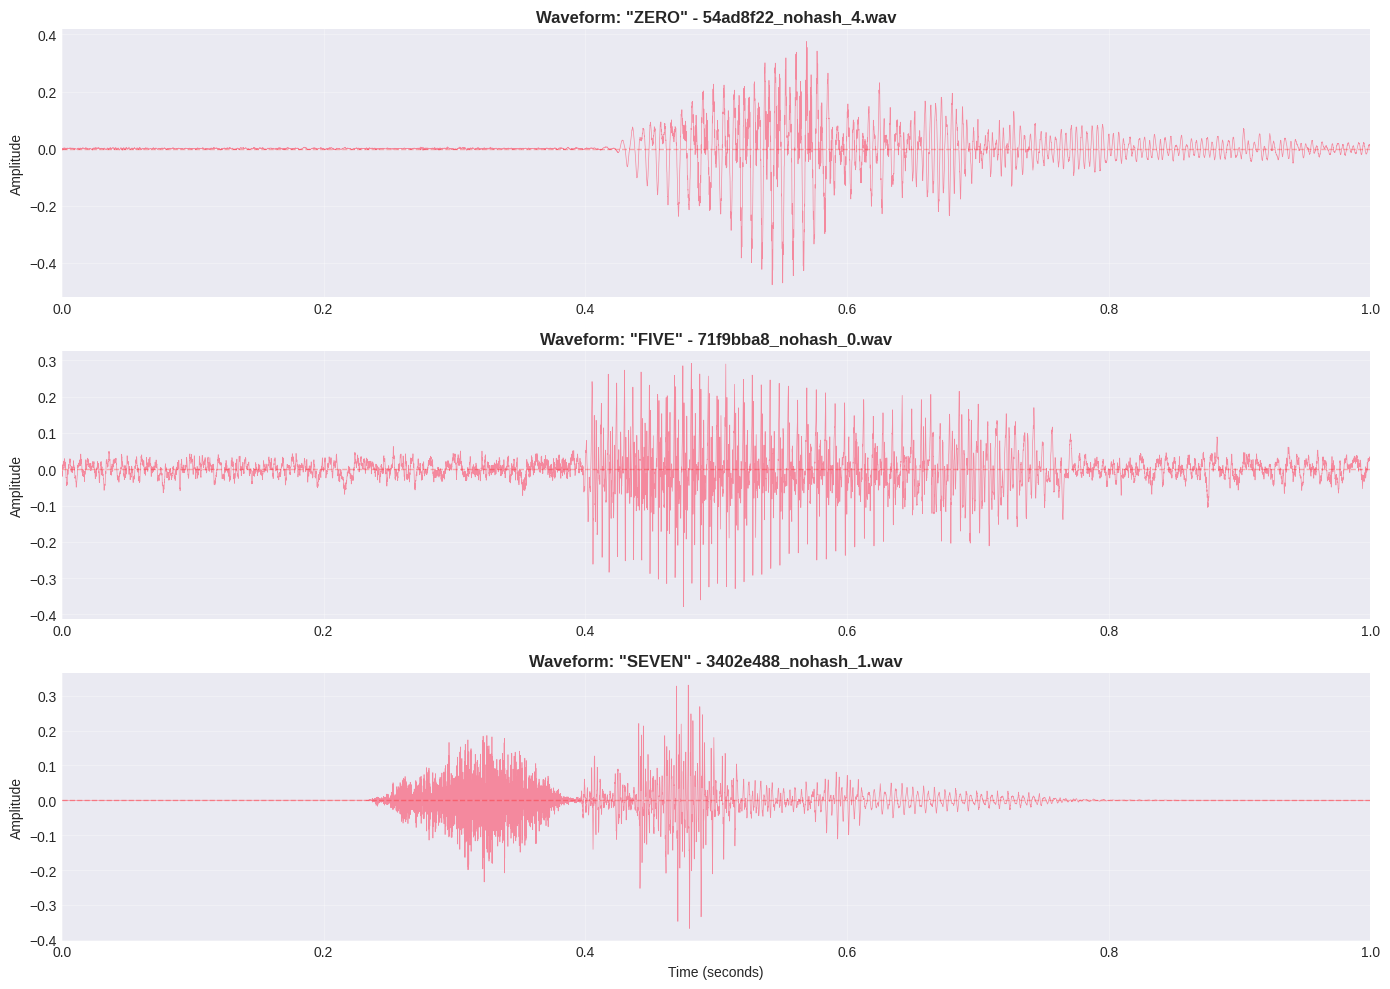


📊 Waveform Observations:
  • Different digits have different temporal patterns
  • Some digits are longer/shorter than others
  • Amplitude varies throughout the utterance
  • Silence at beginning/end of some samples


In [18]:
fig, axes = plt.subplots(len(sample_digits), 1, figsize=(14, 10))

for idx, (digit, data) in enumerate(samples.items()):
    audio = data['audio']
    sr = data['sr']
    
    # Time axis
    time = np.linspace(0, len(audio)/sr, len(audio))
    
    # Plot waveform
    axes[idx].plot(time, audio, linewidth=0.5, alpha=0.8)
    axes[idx].set_ylabel('Amplitude')
    axes[idx].set_title(f'Waveform: "{digit.upper()}" - {data["filename"]}', 
                       fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, len(audio)/sr])
    
    # Add zero line
    axes[idx].axhline(y=0, color='red', linestyle='--', alpha=0.3, linewidth=1)

axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

print("\n📊 Waveform Observations:")
print("  • Different digits have different temporal patterns")
print("  • Some digits are longer/shorter than others")
print("  • Amplitude varies throughout the utterance")
print("  • Silence at beginning/end of some samples")

## 4. Temporal Pattern Analysis

Let's analyze how speech unfolds over time using a detailed example.

### 4.1 Phonetic Breakdown of "SEVEN"

```
┌────────────────────────────────────────────────────────────────────┐
│              TEMPORAL BREAKDOWN: "SEVEN"                           │
└────────────────────────────────────────────────────────────────────┘

Time:     0ms      200ms     400ms     600ms     800ms    1000ms
          │         │         │         │         │         │
          ▼         ▼         ▼         ▼         ▼         ▼
Sound:   [s]   →   [e]   →   [v]   →   [ə]   →   [n]   → [silence]
         │         │         │         │         │         │
Phoneme: /s/       /ɛ/       /v/       /ə/       /n/      
         │         │         │         │         │         │
Type:    Fric.     Vowel     Fric.     Vowel     Nasal    Silent
         │         │         │         │         │         │
Energy:  ▂▂▂▂▂    ▅▅▅▅▅    ▃▃▃▃▃    ▅▅▅▅▅    ▃▃▃▃▃    ▁▁▁▁▁
         │         │         │         │         │         │
Freq:    High      Mid       Low       Mid       Low      Silent
         4-8kHz    1-3kHz    0.5-2kHz  1-3kHz    0.5-1kHz  
         │         │         │         │         │         │
MFCC:   Frame1    Frame2    Frame3    Frame4    Frame5   Frame6...
        [13]      [13]      [13]      [13]      [13]     [13]
         │         │         │         │         │         │
         └─────────┴─────────┴─────────┴─────────┴─────────┘
                            Sequence for RNN
```

### Key Observations:

1. **Temporal Structure**: Speech has clear temporal organization
2. **Phoneme Transitions**: Sounds blend together (co-articulation)
3. **Energy Variation**: Different phonemes have different energy levels
4. **Frequency Content**: Each phoneme has characteristic frequencies
5. **Sequential Nature**: Order matters - "seven" ≠ "neves"

### Why RNNs Are Necessary:

**Problem with Frame-by-Frame (DNN):**
- Frame 2 (vowel /ɛ/) could be from "seven", "ten", "eleven", "set", etc.
- Without context, impossible to disambiguate

**Solution with Sequential (RNN):**
- Frame 1 (/s/) + Frame 2 (/ɛ/) → Likely "seven" or "set"
- Frame 3 (/v/) confirms → Must be "seven"!
- Context resolves ambiguity

### 4.2 Visualize Spectrograms

Spectrograms show frequency content over time - revealing the temporal structure of speech.

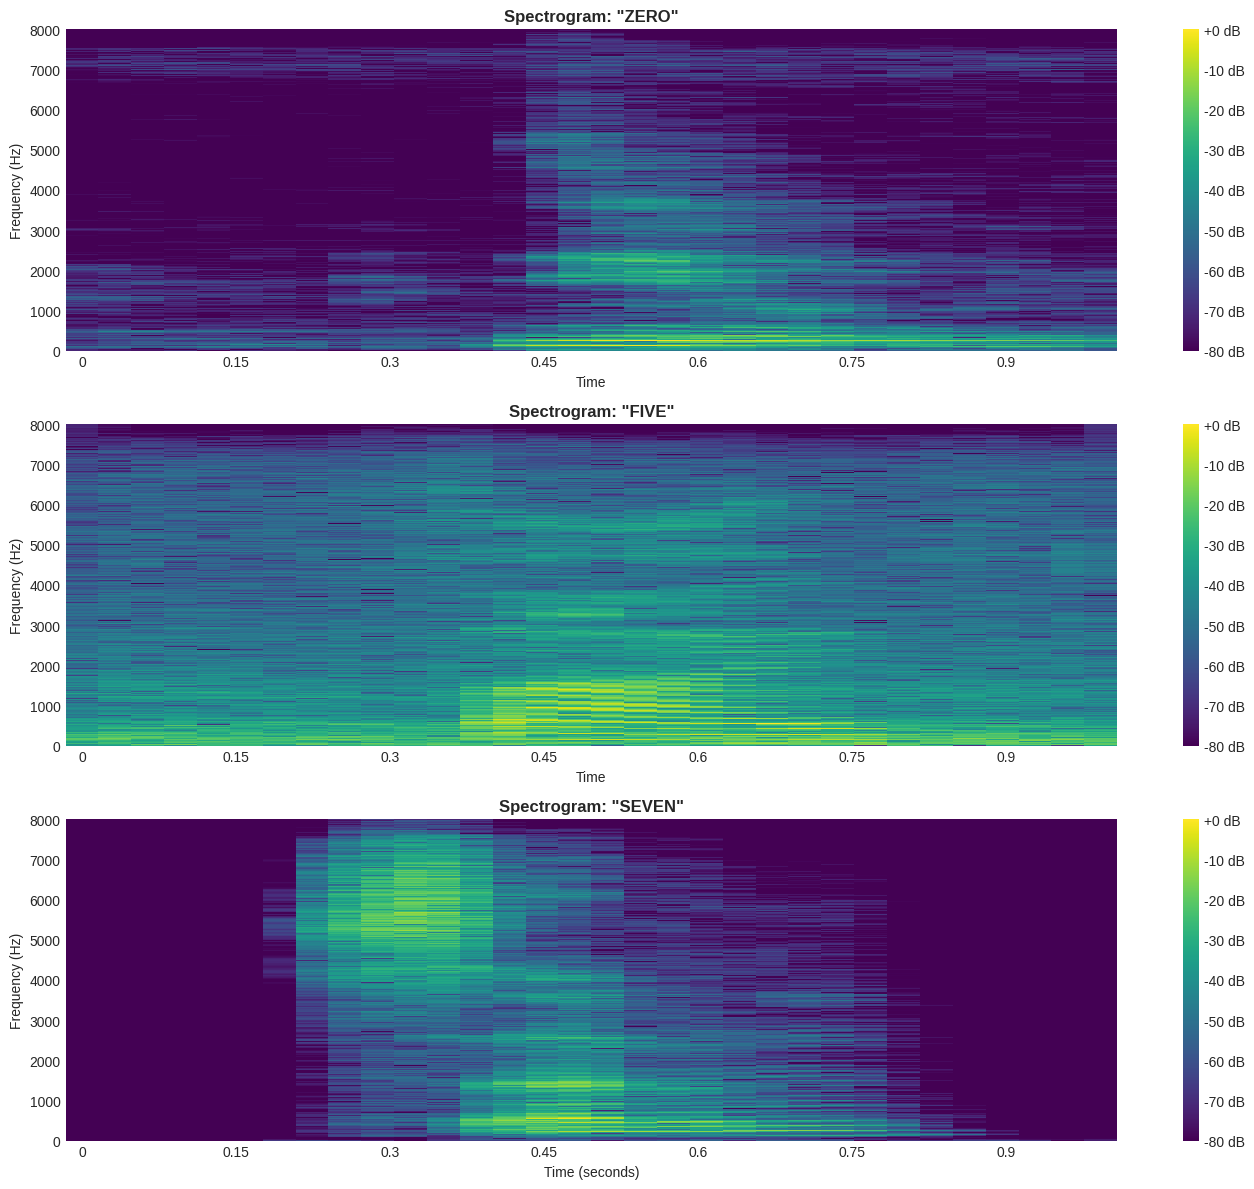


📊 Spectrogram Observations:
  • Horizontal bands = Formants (resonances of vocal tract)
  • Bright regions = High energy at those frequencies
  • Dark regions = Low energy
  • Temporal patterns visible - different for each digit
  • Transitions between phonemes create characteristic patterns


In [19]:
fig, axes = plt.subplots(len(sample_digits), 1, figsize=(14, 12))

for idx, (digit, data) in enumerate(samples.items()):
    audio = data['audio']
    sr = data['sr']
    
    # Compute spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    
    # Plot
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', 
                                    ax=axes[idx], cmap='viridis')
    axes[idx].set_title(f'Spectrogram: "{digit.upper()}"', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Frequency (Hz)')
    axes[idx].set_ylim([0, 8000])
    
    # Add colorbar
    plt.colorbar(img, ax=axes[idx], format='%+2.0f dB')

axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

print("\n📊 Spectrogram Observations:")
print("  • Horizontal bands = Formants (resonances of vocal tract)")
print("  • Bright regions = High energy at those frequencies")
print("  • Dark regions = Low energy")
print("  • Temporal patterns visible - different for each digit")
print("  • Transitions between phonemes create characteristic patterns")

## 5. MFCC Feature Extraction

Now let's extract MFCC features - the input for our RNN.

### 5.1 MFCC Computation Steps

```
┌──────────────────────────────────────────────────────────────┐
│                  MFCC EXTRACTION PROCESS                     │
└──────────────────────────────────────────────────────────────┘

Input: audio[16000] (1 second at 16kHz)
   │
   ▼
┌─────────────────┐
│ 1. Frame Audio  │  window=25ms, hop=10ms
│    into windows │  → 100 frames
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│ 2. Apply        │  Hamming window
│    Windowing    │  → Smooth boundaries
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│ 3. Compute FFT  │  512-point FFT
│                 │  → Power spectrum
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│ 4. Mel Filter   │  40 triangular filters
│    Bank         │  → Mel spectrum
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│ 5. Log          │  log₁₀(mel_spec + ε)
│    Compression  │  → Log mel spectrum
└────────┬────────┘
         │
         ▼
┌─────────────────┐
│ 6. DCT          │  Keep first 13 coeffs
│                 │  → 13 MFCCs
└────────┬────────┘
         │
         ▼
Output: mfcc[100, 13] (100 frames × 13 coefficients)
```

In [20]:
def extract_mfcc(audio, sr=16000, n_mfcc=13, n_fft=512, hop_length=160):
    """Extract MFCC features from audio.
    
    Args:
        audio: Audio signal
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients
        n_fft: FFT window size
        hop_length: Hop length between frames
    
    Returns:
        mfcc: MFCC features (n_frames, n_mfcc)
    """
    # Extract MFCCs
    mfcc = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    
    # Transpose to (time, features)
    mfcc = mfcc.T
    
    return mfcc

# Extract MFCCs for our samples
mfccs = {}
for digit, data in samples.items():
    mfcc = extract_mfcc(data['audio'], data['sr'])
    mfccs[digit] = mfcc
    print(f"{digit:>6}: MFCC shape = {mfcc.shape} (frames × coefficients)")

print("\n✓ MFCC extraction complete!")

  zero: MFCC shape = (101, 13) (frames × coefficients)
  five: MFCC shape = (101, 13) (frames × coefficients)
 seven: MFCC shape = (101, 13) (frames × coefficients)

✓ MFCC extraction complete!


### 5.2 Visualize MFCC Features

MFCCs show the spectral envelope over time - the key features for speech recognition.

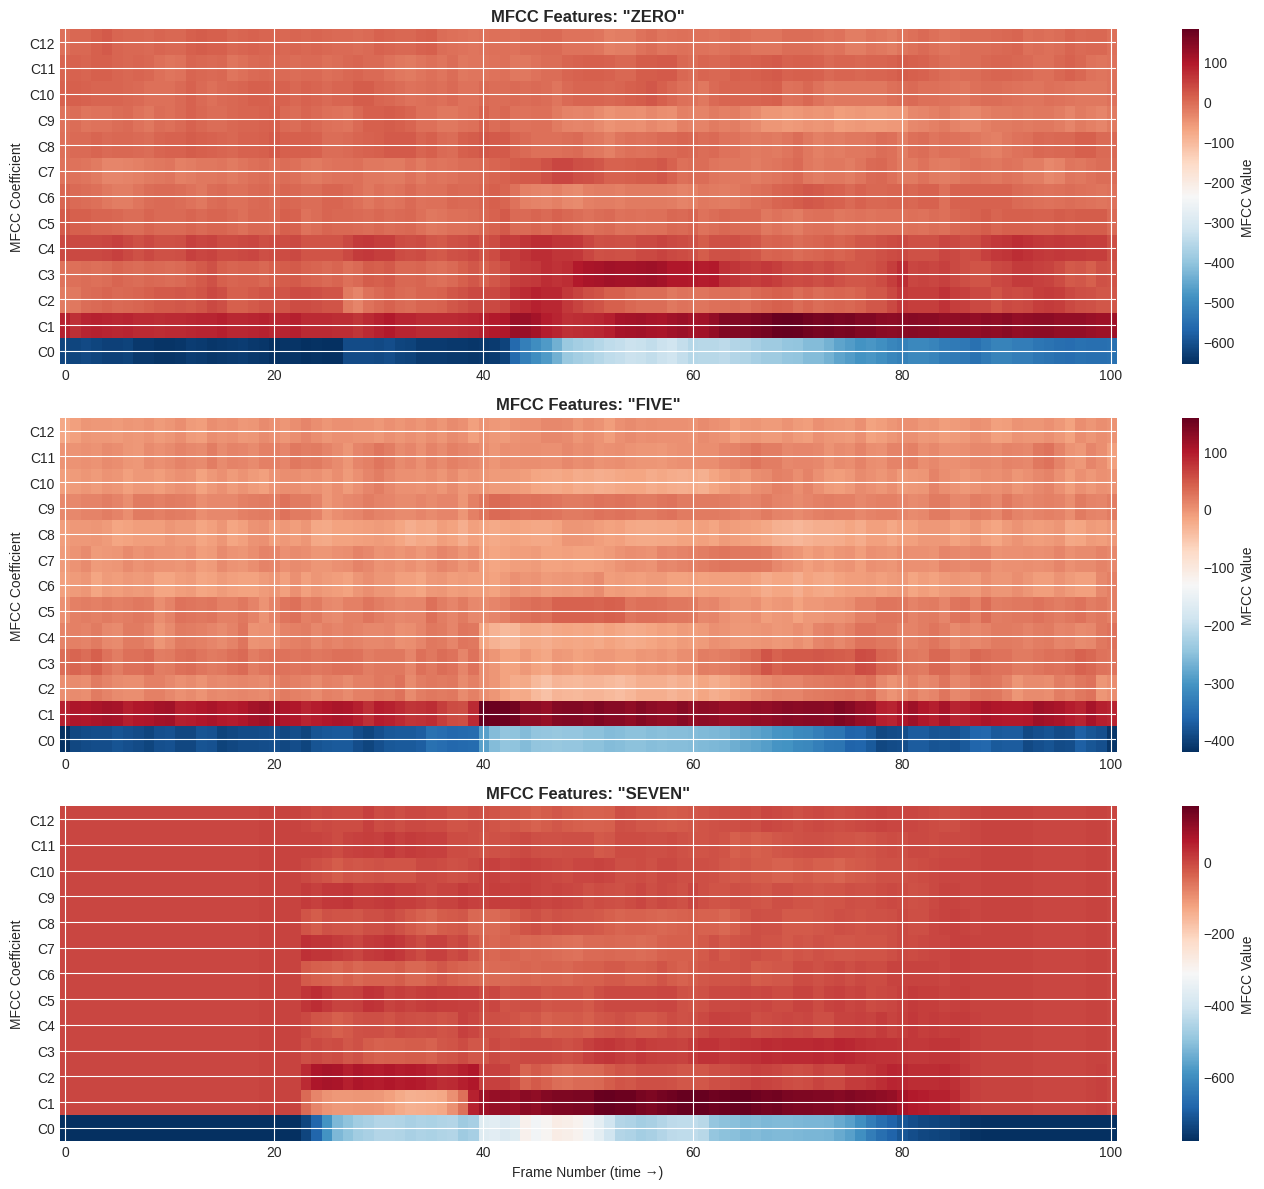


📊 MFCC Observations:
  • Each row = one MFCC coefficient over time
  • Each column = one time frame (10ms)
  • C0 (bottom) = Energy/loudness
  • C1-C12 = Spectral shape information
  • Temporal patterns visible - different for each digit
  • This is the input sequence for our RNN!


In [21]:
fig, axes = plt.subplots(len(sample_digits), 1, figsize=(14, 12))

for idx, (digit, mfcc) in enumerate(mfccs.items()):
    # Plot MFCC heatmap
    im = axes[idx].imshow(mfcc.T, aspect='auto', origin='lower', 
                          cmap='RdBu_r', interpolation='nearest')
    axes[idx].set_ylabel('MFCC Coefficient')
    axes[idx].set_title(f'MFCC Features: "{digit.upper()}"', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_yticks(range(13))
    axes[idx].set_yticklabels([f'C{i}' for i in range(13)])
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx], label='MFCC Value')

axes[-1].set_xlabel('Frame Number (time →)')
plt.tight_layout()
plt.show()

print("\n📊 MFCC Observations:")
print("  • Each row = one MFCC coefficient over time")
print("  • Each column = one time frame (10ms)")
print("  • C0 (bottom) = Energy/loudness")
print("  • C1-C12 = Spectral shape information")
print("  • Temporal patterns visible - different for each digit")
print("  • This is the input sequence for our RNN!")

## 6. Prepare Dataset for Training

Now let's process all audio files and create train/validation/test splits.

In [23]:
def load_dataset(data_dir, digits, max_samples_per_digit=None, sr=16000, max_frames=None):
    """Load and process entire dataset.
    
    Args:
        data_dir: Path to data directory
        digits: List of digit names
        max_samples_per_digit: Maximum samples per digit (None = all)
        sr: Sample rate
        max_frames: Maximum number of frames (None = auto-detect)
    
    Returns:
        X: MFCC features (n_samples, n_frames, n_mfcc)
        y: Labels (n_samples,)
        label_map: Dictionary mapping digit names to indices
    """
    X_list = []
    y_list = []
    label_map = {digit: idx for idx, digit in enumerate(digits)}
    
    print("Loading dataset...")
    
    # First pass: determine max_frames if not specified
    if max_frames is None:
        print("  Determining maximum audio length...")
        max_frames = 0
        for digit in digits:
            digit_path = data_dir / digit
            audio_files = list(digit_path.glob('*.wav'))
            if max_samples_per_digit:
                audio_files = audio_files[:max_samples_per_digit]
            
            for audio_file in audio_files[:10]:  # Sample first 10 files
                try:
                    audio, _ = librosa.load(audio_file, sr=sr)
                    mfcc = extract_mfcc(audio, sr)
                    max_frames = max(max_frames, mfcc.shape[0])
                except:
                    continue
        
        # Add some buffer
        max_frames = int(max_frames * 1.2)
        print(f"  Using max_frames: {max_frames}")
    
    # Second pass: load and pad
    for digit in digits:
        digit_path = data_dir / digit
        audio_files = list(digit_path.glob('*.wav'))
        
        # Limit samples if specified
        if max_samples_per_digit:
            audio_files = audio_files[:max_samples_per_digit]
        
        print(f"  Processing {digit}: {len(audio_files)} samples")
        
        for audio_file in tqdm(audio_files, desc=f"  {digit}", leave=False):
            try:
                # Load audio
                audio, _ = librosa.load(audio_file, sr=sr)
                
                # Extract MFCCs
                mfcc = extract_mfcc(audio, sr)
                
                # Pad or truncate to max_frames
                if mfcc.shape[0] < max_frames:
                    # Pad with zeros
                    pad_width = max_frames - mfcc.shape[0]
                    mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
                else:
                    # Truncate
                    mfcc = mfcc[:max_frames, :]
                
                # Store
                X_list.append(mfcc)
                y_list.append(label_map[digit])
                
            except Exception as e:
                print(f"    Error loading {audio_file.name}: {e}")
                continue
    
    # Convert to arrays
    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y, label_map

# Load dataset (limit to 200 samples per digit for faster processing)
print("Loading Speech Commands dataset...")
print("(Using 200 samples per digit for faster training)\n")

X, y, label_map = load_dataset(DATA_DIR, DIGITS, max_samples_per_digit=200)

print(f"\n✓ Dataset loaded!")
print(f"  X shape: {X.shape} (samples, frames, mfcc_coeffs)")
print(f"  y shape: {y.shape} (samples,)")
print(f"  Label map: {label_map}")

Loading Speech Commands dataset...
(Using 200 samples per digit for faster training)

Loading dataset...
  Determining maximum audio length...
  Using max_frames: 121
  Processing zero: 200 samples


  Processing one: 200 samples


  Processing two: 200 samples


  Processing three: 200 samples


  Processing four: 200 samples


  Processing five: 200 samples


  Processing six: 200 samples


  Processing seven: 200 samples


  Processing eight: 200 samples


  Processing nine: 200 samples



✓ Dataset loaded!
  X shape: (2000, 121, 13) (samples, frames, mfcc_coeffs)
  y shape: (2000,) (samples,)
  Label map: {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}


In [24]:
# Create train/validation/test splits
from sklearn.model_selection import train_test_split

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% val (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Dataset splits:")
print(f"  Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check class distribution
print("\nClass distribution (train):")
for digit, idx in label_map.items():
    count = np.sum(y_train == idx)
    print(f"  {digit:>6}: {count:>3} samples")

Dataset splits:
  Train: 1200 samples (60.0%)
  Val:   400 samples (20.0%)
  Test:  400 samples (20.0%)

Class distribution (train):
    zero: 120 samples
     one: 120 samples
     two: 120 samples
   three: 120 samples
    four: 120 samples
    five: 120 samples
     six: 120 samples
   seven: 120 samples
   eight: 120 samples
    nine: 120 samples


## 7. Save Processed Data

Save the processed data for use in the next notebook.

In [25]:
# Save processed data
np.savez_compressed(
    'speech_commands_processed.npz',
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    label_map=label_map,
    digits=DIGITS
)

print("✓ Processed data saved to 'speech_commands_processed.npz'")
print("\nReady for RNN training in Notebook 2B!")

✓ Processed data saved to 'speech_commands_processed.npz'

Ready for RNN training in Notebook 2B!


## Summary

### What We Accomplished:

✅ **Downloaded real speech data** - Speech Commands digits (~200MB)  
✅ **Understood the pipeline** - From raw audio to MFCC features  
✅ **Visualized temporal patterns** - Waveforms, spectrograms, MFCCs  
✅ **Extracted features** - 13 MFCCs per frame, ~100 frames per audio  
✅ **Prepared dataset** - Train/val/test splits ready for training

### Key Insights:

1. **Real speech has temporal structure** - Phonemes unfold over time
2. **Co-articulation creates ambiguity** - Individual frames are ambiguous
3. **Context is essential** - Need previous frames to disambiguate
4. **MFCCs capture essential information** - Compact, perceptually motivated
5. **Sequences matter** - Order of frames is crucial

### Next Steps:

In **Notebook 2B**, we'll:
1. Train a DNN baseline (frame-by-frame classification)
2. Train an RNN (sequential classification)
3. Compare performance (expect 15-25% improvement)
4. Analyze where each model succeeds/fails
5. Visualize what the RNN learns

**The real data will clearly demonstrate why RNNs are necessary for sequence tasks!** 🎯